In [15]:
!rm -rf /content/drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [16]:
# --- INSTALLS (Colab) ---
# Restart runtime after running this cell if you get import errors
!pip install -q --upgrade pip
!pip install -q scikit-learn==1.5.2
!pip install -q nltk==3.9.1 xgboost==2.1.1 tqdm==4.66.5
!pip install -q lightgbm==4.5.0

# Note: If you see warnings about umap-learn, you can safely ignore them
# or run: !pip uninstall -y umap-learn

# --- IMPORTS ---
import os, re, string, pickle, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from tqdm import tqdm
from pprint import pprint

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve, auc,
                             average_precision_score, precision_recall_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight


from scipy import sparse

# --- TEXT PREP (NLTK) ---
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

# --- TF-IDF ---
from sklearn.feature_extraction.text import TfidfVectorizer

# --- PLOTTING ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.dpi"] = 130

RNG = 42
N_CLASSES = 3



# --- PATHS ---
CSV_PATH = "/content/drive/MyDrive/THESIS 47/Saved Datasets/Composite2_194k data.csv"
BASE_SAVE_DIR = "/content/drive/MyDrive/THESIS 47/ClassicML_Multiclass"
os.makedirs(BASE_SAVE_DIR, exist_ok=True)

# --- LOAD ---
df = pd.read_csv(CSV_PATH)

# --- BASIC CLEANING (MULTICLASS VERSION) ---
need = ['title','reviewText','target_label','tomatoMeter','genre','audienceScore',
        'runtimeMinutes','language_encoded','director_encoded']
missing = [c for c in need if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

# Drop rows with missing target or review text
df = df.dropna(subset=['reviewText','target_label']).copy()
df['label'] = df['target_label'].astype(int)

# Verify we have 3 classes: 0 (Negative), 1 (Neutral), 2 (Positive)
assert df['label'].isin([0, 1, 2]).all(), "Labels must be 0, 1, or 2"

# Keep only needed columns
df['title'] = df['title'].fillna("")
df['genre'] = df['genre'].fillna("Unknown")

class_names = ['Negative', 'Neutral', 'Positive']
print("Rows:", len(df))
print("Class distribution:")
print(df['label'].value_counts().sort_index())
print("\nClass proportions:")
print(df['label'].value_counts(normalize=True).sort_index().round(4))

# --- TEXT PREPROCESSING ---
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    s = s.lower()
    # contractions (quick pass)
    s = re.sub(r"'", "'", s)
    s = re.sub(r"n't\b", " not", s)
    s = re.sub(r"'re\b", " are", s)
    s = re.sub(r"'s\b", " is", s)
    s = re.sub(r"'d\b", " would", s)
    s = re.sub(r"'ll\b", " will", s)
    s = re.sub(r"'ve\b", " have", s)
    s = re.sub(r"'m\b", " am", s)
    # remove urls/emails/handles
    s = re.sub(r"http\S+|www\.\S+|[\w\.-]+@[\w\.-]+", " ", s)
    # keep letters only
    s = re.sub(r"[^a-z\s]", " ", s)
    # tokenize → remove stopwords → lemmatize → (light) stem
    tokens = [w for w in word_tokenize(s) if w not in STOPWORDS and len(w) > 2]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    stems  = [stemmer.stem(w) for w in lemmas]
    return " ".join(stems)

def fit_tfidf(train_texts, max_features=50000, ngram_range=(1,2), min_df=3):
    vec = TfidfVectorizer(
        preprocessor=None,
        tokenizer=None,
        analyzer='word',
        ngram_range=ngram_range,
        min_df=min_df,
        max_features=max_features,
        lowercase=False,
        dtype=np.float32
    )
    X = vec.fit_transform(train_texts)
    return vec, X

def transform_tfidf(vec, texts):
    return vec.transform(texts)

print("\n✅ Part 1 Complete: Data loaded and preprocessing functions defined.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Rows: 194784
Class distribution:
label
0    55029
1    66081
2    73674
Name: count, dtype: int64

Class proportions:
label
0    0.2825
1    0.3393
2    0.3782
Name: proportion, dtype: float64

✅ Part 1 Complete: Data loaded and preprocessing functions defined.


In [17]:
# --- MULTICLASS FEATURE ENGINEERING ---

NUM_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']

# =======================================================
# MULTICLASS DIRECTOR BLOCKS (Target Encoding)
# =======================================================
def director_blocks_multiclass(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, n_splits: int = 5):
    """
    Multiclass Target Encoding: Calculates mean for each class (0, 1, 2)
    Returns 1 freq col + 3 target mean cols (4 total features per director).
    """
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # 1. Frequency features (log1p)
    freq = s_train.value_counts()
    tr_freq = np.log1p(s_train.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)
    te_freq = np.log1p(s_test.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)

    # 2. Multiclass Target mean encoding (leak-safe OOF)
    y_ohe = OneHotEncoder(categories=[range(N_CLASSES)], sparse_output=False, dtype=np.float32).fit_transform(y.reshape(-1, 1))
    global_mean = y_ohe.mean(axis=0)

    tr_te = np.zeros((len(s_train), N_CLASSES), dtype=np.float32)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)

    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_fold = s_train.iloc[tr_i]
        fold_means = pd.DataFrame(y_ohe[tr_i], index=tr_fold.index).groupby(tr_fold).mean()

        val_fold = s_train.iloc[val_i].to_frame(name='did')
        merged = val_fold.merge(fold_means, left_on='did', right_index=True, how='left')
        vals = merged.drop('did', axis=1).values

        mask = np.isnan(vals.sum(axis=1))
        vals[mask] = global_mean
        tr_te[val_i] = vals.astype(np.float32)

    # Test set mapping (using full train)
    full_means = pd.DataFrame(y_ohe, index=s_train.index).groupby(s_train).mean()
    test_df_map = s_test.to_frame(name='did')
    merged_test = test_df_map.merge(full_means, left_on='did', right_index=True, how='left')
    te_te = merged_test.drop('did', axis=1).values

    mask_test = np.isnan(te_te.sum(axis=1))
    te_te[mask_test] = global_mean

    return tr_freq, te_freq, tr_te, te_te

# =======================================================
# GENRE & LANGUAGE ENCODINGS
# =======================================================
def fit_categoricals(train_genre, train_lang):
    mlb = MultiLabelBinarizer()
    G = mlb.fit_transform(train_genre)

    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True, dtype=np.float32)
    L = ohe.fit_transform(train_lang.to_frame(name="lang"))
    return mlb, ohe, G, L

def transform_categoricals(mlb, ohe, genre_series, lang_series):
    G = mlb.transform(genre_series)
    L = ohe.transform(lang_series.to_frame(name="lang"))
    return G, L

# =======================================================
# NUMERICS: scale on TRAIN only
# =======================================================
def fit_scale_numeric(train_df, cols):
    scaler = StandardScaler()
    X = scaler.fit_transform(train_df[cols].fillna(train_df[cols].median()))
    return scaler, X

def transform_scale_numeric(scaler, df, cols):
    return scaler.transform(df[cols].fillna(df[cols].median()))

# =======================================================
# TRAIN/TEST SPLIT (Stratified by 3 classes)
# =======================================================
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=RNG, stratify=df['label']
)
y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"\nTrain size: {len(train_df)} | Test size: {len(test_df)}")
print("Train class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nTest class distribution:")
print(pd.Series(y_test).value_counts().sort_index())

# =======================================================
# COMPUTE CLASS WEIGHTS (for imbalanced 3-class data)
# =======================================================
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
print(f"\nClass weights: {class_weight_dict}")

print("\n✅ Part 2 Complete: Feature engineering functions and train/test split ready.")


Train size: 155827 | Test size: 38957
Train class distribution:
0    44023
1    52865
2    58939
Name: count, dtype: int64

Test class distribution:
0    11006
1    13216
2    14735
Name: count, dtype: int64

Class weights: {0: np.float64(1.1798908146499179), 1: np.float64(0.9825467385478736), 2: np.float64(0.8812896949953907)}

✅ Part 2 Complete: Feature engineering functions and train/test split ready.


In [18]:
# =======================================================
# MULTICLASS EVALUATION & PLOTTING (4-DECIMAL PRECISION)
# =======================================================

def kfold_cv_report(model, X, y, name, n_splits=5):
    """
    Multiclass K-Fold CV with Weighted F1.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)
    scores = []

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        mdl = pickle.loads(pickle.dumps(model))
        mdl.fit(X[tr], y[tr])
        pred = mdl.predict(X[va])
        acc = accuracy_score(y[va], pred)
        f1  = precision_recall_fscore_support(y[va], pred, average='weighted', zero_division=0)[2]
        scores.append((acc, f1))
        print(f"  Fold {fold}: acc={acc:.4f} | f1_weighted={f1:.4f}")

    arr = np.array(scores)
    print(f"  {name} CV mean±std | acc={arr[:,0].mean():.4f}±{arr[:,0].std():.4f} f1_w={arr[:,1].mean():.4f}±{arr[:,1].std():.4f}")

def evaluate_and_plot(model_name, setup_name, y_true, y_prob, y_pred, save_dir, class_names=['Negative', 'Neutral', 'Positive']):
    """
    Multiclass evaluation with 4-decimal precision.
    """
    os.makedirs(save_dir, exist_ok=True)
    n_classes = len(class_names)

    # Calculate metrics with weighted average (for imbalanced data)
    acc  = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n[{setup_name} | {model_name}]")
    print(f"Accuracy={acc:.4f}  F1_weighted={f1:.4f}  Precision_weighted={pr:.4f}  Recall_weighted={rc:.4f}")

    # ⭐ 4-DECIMAL CLASSIFICATION REPORT
    print("\n--- Classification Report (4 Decimal Places) ---")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0, digits=4)
    print(report)

    # ⭐ CONFUSION MATRIX (Counts + Normalized with 4 decimals)
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 5))

    # Counts (Integers)
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{setup_name} | {model_name}\nConfusion Matrix (Counts)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # ⭐ 4-DECIMAL NORMALIZED CONFUSION MATRIX
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{setup_name} | {model_name}\nConfusion Matrix (Normalized, 4-Decimals)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_{setup_name}_confusion.png'), dpi=130, bbox_inches='tight')
    plt.show()

    # Per-class metrics
    pr_per_class, rc_per_class, f1_per_class, support = precision_recall_fscore_support(
        y_true, y_pred, labels=range(n_classes), zero_division=0
    )

    print("\n--- Per-Class Metrics (4 Decimals) ---")
    for i, cname in enumerate(class_names):
        print(f"{cname:10s}: Precision={pr_per_class[i]:.4f}  Recall={rc_per_class[i]:.4f}  F1={f1_per_class[i]:.4f}  Support={support[i]}")

    return {
        "accuracy": acc,
        "f1_weighted": f1,
        "precision_weighted": pr,
        "recall_weighted": rc,
        "per_class_precision": pr_per_class,
        "per_class_recall": rc_per_class,
        "per_class_f1": f1_per_class
    }

print("\n✅ Part 3 Complete: Multiclass evaluation helpers ready (4-decimal precision).")


✅ Part 3 Complete: Multiclass evaluation helpers ready (4-decimal precision).


In [19]:
# =======================================================
# BUILD ALL FEATURE MATRICES (8 Features: Review + Title + Num + Genre + Lang + Director)
# =======================================================

print("--- Building ALL Features Matrix ---")

# ---- TEXT FEATURES ----
# 1. Review Text
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)
tfidf_review, Xtr_review = fit_tfidf(train_review, max_features=60000, ngram_range=(1,2), min_df=3)
Xte_review = transform_tfidf(tfidf_review, test_review)

# 2. Title Text
train_title = train_df['title'].map(clean_text)
test_title  = test_df['title'].map(clean_text)
tfidf_title, Xtr_title = fit_tfidf(train_title, max_features=30000, ngram_range=(1,2), min_df=3)
Xte_title = transform_tfidf(tfidf_title, test_title)

# ---- NUMERIC FEATURES ----
scaler_all, Xtr_num_np = fit_scale_numeric(train_df, NUM_COLS)
Xte_num_np = transform_scale_numeric(scaler_all, test_df, NUM_COLS)
Xtr_num = sparse.csr_matrix(Xtr_num_np.astype(np.float32))
Xte_num = sparse.csr_matrix(Xte_num_np.astype(np.float32))

# ---- CATEGORICAL FEATURES ----
# Genre (multi-label)
train_genre = train_df['genre'].fillna("Unknown").str.split(', ')
test_genre  = test_df['genre'].fillna("Unknown").str.split(', ')

# Language (single label)
train_lang  = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')
test_lang   = test_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

mlb_all, ohe_all, Xtr_genre, Xtr_lang = fit_categoricals(train_genre, train_lang)
Xte_genre, Xte_lang = transform_categoricals(mlb_all, ohe_all, test_genre, test_lang)

Xtr_genre = sparse.csr_matrix(Xtr_genre.astype(np.float32))
Xte_genre = sparse.csr_matrix(Xte_genre.astype(np.float32))

# ---- DIRECTOR FEATURES (Multiclass Target Encoding) ----
tr_f, te_f, tr_te, te_te = director_blocks_multiclass(
    train_df['director_encoded'], y_train, test_df['director_encoded']
)
Xtr_dir = sparse.csr_matrix(np.concatenate([tr_f, tr_te], axis=1).astype(np.float32))
Xte_dir = sparse.csr_matrix(np.concatenate([te_f, te_te], axis=1).astype(np.float32))

# ---- STACK ALL FEATURES ----
X_train_ALL = sparse.hstack([Xtr_review, Xtr_title, Xtr_num, Xtr_genre, Xtr_lang, Xtr_dir], format='csr')
X_test_ALL  = sparse.hstack([Xte_review, Xte_title, Xte_num, Xte_genre, Xte_lang, Xte_dir], format='csr')

print("\n--- Feature Matrix Stacking Complete ---")
print(f"X_train_ALL shape: {X_train_ALL.shape}")
print(f"X_test_ALL shape:  {X_test_ALL.shape}")
print(f"Features include: Review TF-IDF, Title TF-IDF, Numerics, Genre, Language, Director (Total: {X_train_ALL.shape[1]} features)")

print("\n✅ Part 4 Complete: ALL features matrix ready.")

--- Building ALL Features Matrix ---

--- Feature Matrix Stacking Complete ---
X_train_ALL shape: (155827, 83942)
X_test_ALL shape:  (38957, 83942)
Features include: Review TF-IDF, Title TF-IDF, Numerics, Genre, Language, Director (Total: 83942 features)

✅ Part 4 Complete: ALL features matrix ready.



**This has too much overfitting. Should not be considered.**



LOGISTIC REGRESSION — ALL FEATURES (Multiclass)

Running 5-Fold Cross-Validation...
  Fold 1: acc=0.6447 | f1_weighted=0.6400
  Fold 2: acc=0.6456 | f1_weighted=0.6411
  Fold 3: acc=0.6440 | f1_weighted=0.6399
  Fold 4: acc=0.6442 | f1_weighted=0.6407
  Fold 5: acc=0.6473 | f1_weighted=0.6434
  LogReg (ALL Features) CV mean±std | acc=0.6452±0.0012 f1_w=0.6410±0.0013

Training on full training set...

TRAIN SET PERFORMANCE

[ALL_FEATURES_TRAIN | LogisticRegression]
Accuracy=0.7685  F1_weighted=0.7664  Precision_weighted=0.7665  Recall_weighted=0.7685

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.7548    0.8156    0.7840     44023
     Neutral     0.7190    0.6455    0.6803     52865
    Positive     0.8177    0.8435    0.8304     58939

    accuracy                         0.7685    155827
   macro avg     0.7638    0.7682    0.7649    155827
weighted avg     0.7665    0.7685    0.7664    155827



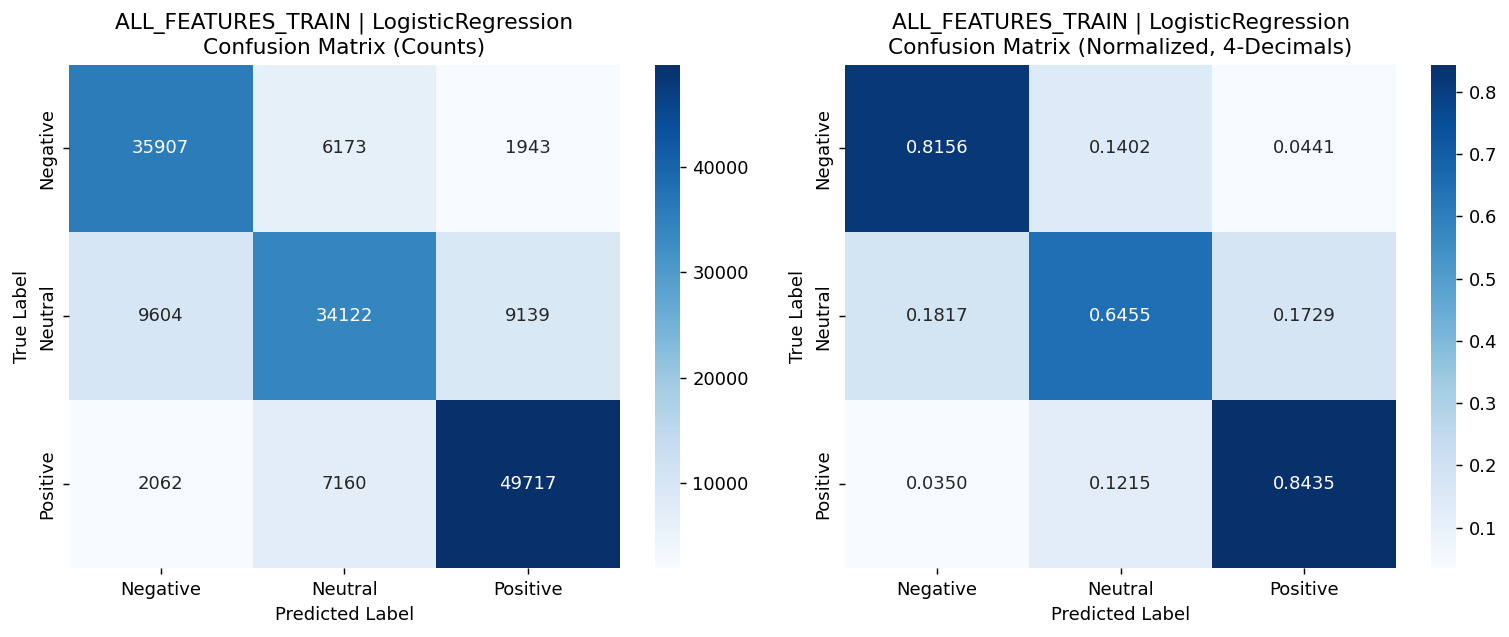


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.7548  Recall=0.8156  F1=0.7840  Support=44023
Neutral   : Precision=0.7190  Recall=0.6455  F1=0.6803  Support=52865
Positive  : Precision=0.8177  Recall=0.8435  F1=0.8304  Support=58939

TEST SET PERFORMANCE

[ALL_FEATURES_TEST | LogisticRegression]
Accuracy=0.6522  F1_weighted=0.6486  Precision_weighted=0.6468  Recall_weighted=0.6522

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.6455    0.6923    0.6681     11006
     Neutral     0.5391    0.4821    0.5090     13216
    Positive     0.7444    0.7748    0.7593     14735

    accuracy                         0.6522     38957
   macro avg     0.6430    0.6497    0.6455     38957
weighted avg     0.6468    0.6522    0.6486     38957



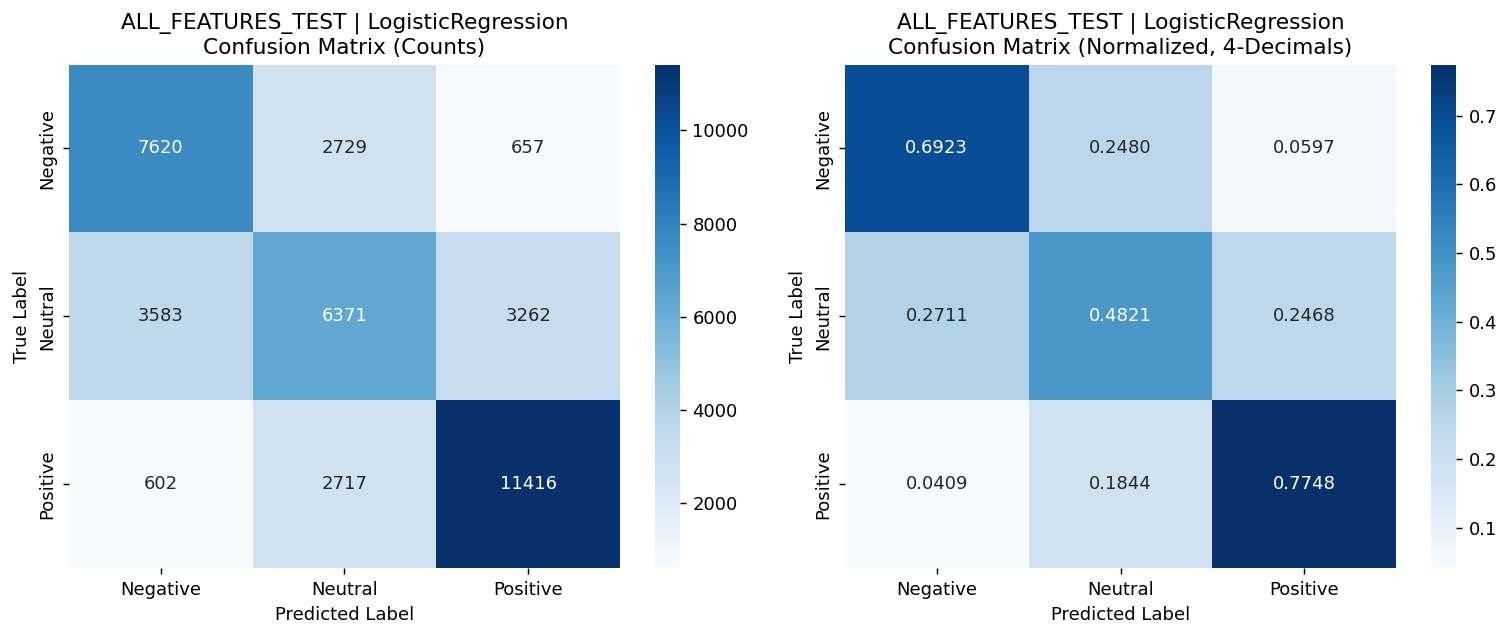


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6455  Recall=0.6923  F1=0.6681  Support=11006
Neutral   : Precision=0.5391  Recall=0.4821  F1=0.5090  Support=13216
Positive  : Precision=0.7444  Recall=0.7748  F1=0.7593  Support=14735

✅ Model saved to: /content/drive/MyDrive/THESIS 47/ClassicML_Multiclass/ALL_FEATURES/LogReg_ALL_Multiclass.pkl

SUMMARY - LogReg ALL Features (Multiclass)
Train Accuracy: 0.7685 | F1_weighted: 0.7664
Test  Accuracy: 0.6522 | F1_weighted: 0.6486



In [20]:
# ======================================================================
# LOGISTIC REGRESSION — ALL FEATURES (Multiclass with Class Weights)
# ======================================================================

from sklearn.linear_model import LogisticRegression

setup = "ALL_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"LOGISTIC REGRESSION — ALL FEATURES (Multiclass)")
print(f"{'='*70}")

# ⭐ MULTICLASS LOGISTIC REGRESSION with class weights
logreg_all = LogisticRegression(
    penalty="l2",
    C=0.5,  # Strong L2 regularization
    solver="lbfgs",
    max_iter=3500,
    n_jobs=-1,
    multi_class='multinomial',  # ⭐ CRITICAL for multiclass
    class_weight=class_weight_dict,  # ⭐ Handle class imbalance
    random_state=RNG
)

# ---- K-FOLD CROSS-VALIDATION ----
print("\nRunning 5-Fold Cross-Validation...")
kfold_cv_report(logreg_all, X_train_ALL, y_train, "LogReg (ALL Features)")

# ---- FIT ON FULL TRAIN ----
print("\nTraining on full training set...")
logreg_all.fit(X_train_ALL, y_train)

# ---- PREDICTIONS ----
train_pred = logreg_all.predict(X_train_ALL)
test_pred = logreg_all.predict(X_test_ALL)

try:
    test_prob = logreg_all.predict_proba(X_test_ALL)
    train_prob = logreg_all.predict_proba(X_train_ALL)
except Exception as e:
    test_prob = None
    train_prob = None
    print(f"Warning: Could not get probability scores: {e}")

# ---- EVALUATION ----
print(f"\n{'='*70}")
print("TRAIN SET PERFORMANCE")
print(f"{'='*70}")
train_metrics = evaluate_and_plot(
    "LogisticRegression",
    f"{setup}_TRAIN",
    y_train,
    train_prob,
    train_pred,
    save_dir
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE")
print(f"{'='*70}")
test_metrics = evaluate_and_plot(
    "LogisticRegression",
    f"{setup}_TEST",
    y_test,
    test_prob,
    test_pred,
    save_dir
)

# ---- SAVE MODEL ----
model_path = os.path.join(save_dir, "LogReg_ALL_Multiclass.pkl")
with open(model_path, "wb") as f:
    pickle.dump({
        "model": logreg_all,
        "tfidf_review": tfidf_review,
        "tfidf_title": tfidf_title,
        "scaler": scaler_all,
        "mlb": mlb_all,
        "ohe": ohe_all,
        "num_cols": NUM_COLS,
        "class_names": class_names,
        "class_weight_dict": class_weight_dict
    }, f)

print(f"\n✅ Model saved to: {model_path}")
print(f"\n{'='*70}")
print(f"SUMMARY - LogReg ALL Features (Multiclass)")
print(f"{'='*70}")
print(f"Train Accuracy: {train_metrics['accuracy']:.4f} | F1_weighted: {train_metrics['f1_weighted']:.4f}")
print(f"Test  Accuracy: {test_metrics['accuracy']:.4f} | F1_weighted: {test_metrics['f1_weighted']:.4f}")
print(f"{'='*70}\n")


LOGISTIC REGRESSION — TOP 4 FEATURES (Multiclass)

Building TOP-4 feature matrices...
X_train_TOP4 shape: (155827, 83922)
X_test_TOP4 shape:  (38957, 83922)

Searching for optimal C with strong L2 regularization...
Selected optimal C: 0.100000

Running 5-Fold Cross-Validation with tuned C...
  Fold 1: acc=0.6318 | f1_weighted=0.6229
  Fold 2: acc=0.6301 | f1_weighted=0.6215
  Fold 3: acc=0.6296 | f1_weighted=0.6211
  Fold 4: acc=0.6274 | f1_weighted=0.6193
  Fold 5: acc=0.6323 | f1_weighted=0.6237
  LogReg (TOP 4 Features) CV mean±std | acc=0.6303±0.0017 f1_w=0.6217±0.0015

Training on full training set...

TRAIN SET PERFORMANCE

[TOP4_FEATURES_TRAIN | LogisticRegression]
Accuracy=0.6866  F1_weighted=0.6807  Precision_weighted=0.6813  Recall_weighted=0.6866

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.6685    0.7443    0.7044     44023
     Neutral     0.6245    0.5047    0.5583     52865
    Positive     0

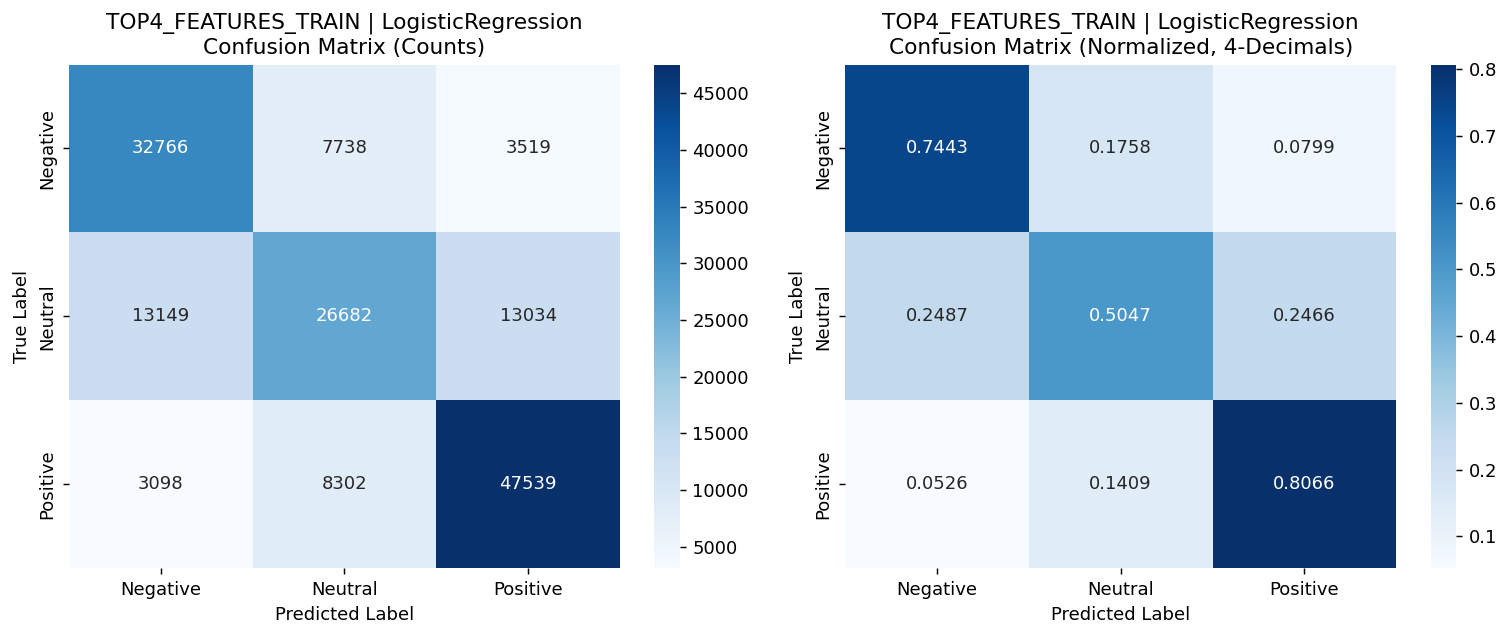


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6685  Recall=0.7443  F1=0.7044  Support=44023
Neutral   : Precision=0.6245  Recall=0.5047  F1=0.5583  Support=52865
Positive  : Precision=0.7417  Recall=0.8066  F1=0.7728  Support=58939

TEST SET PERFORMANCE

[TOP4_FEATURES_TEST | LogisticRegression]
Accuracy=0.6394  F1_weighted=0.6320  Precision_weighted=0.6306  Recall_weighted=0.6394

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.6272    0.6960    0.6598     11006
     Neutral     0.5399    0.4349    0.4817     13216
    Positive     0.7145    0.7805    0.7460     14735

    accuracy                         0.6394     38957
   macro avg     0.6272    0.6371    0.6292     38957
weighted avg     0.6306    0.6394    0.6320     38957



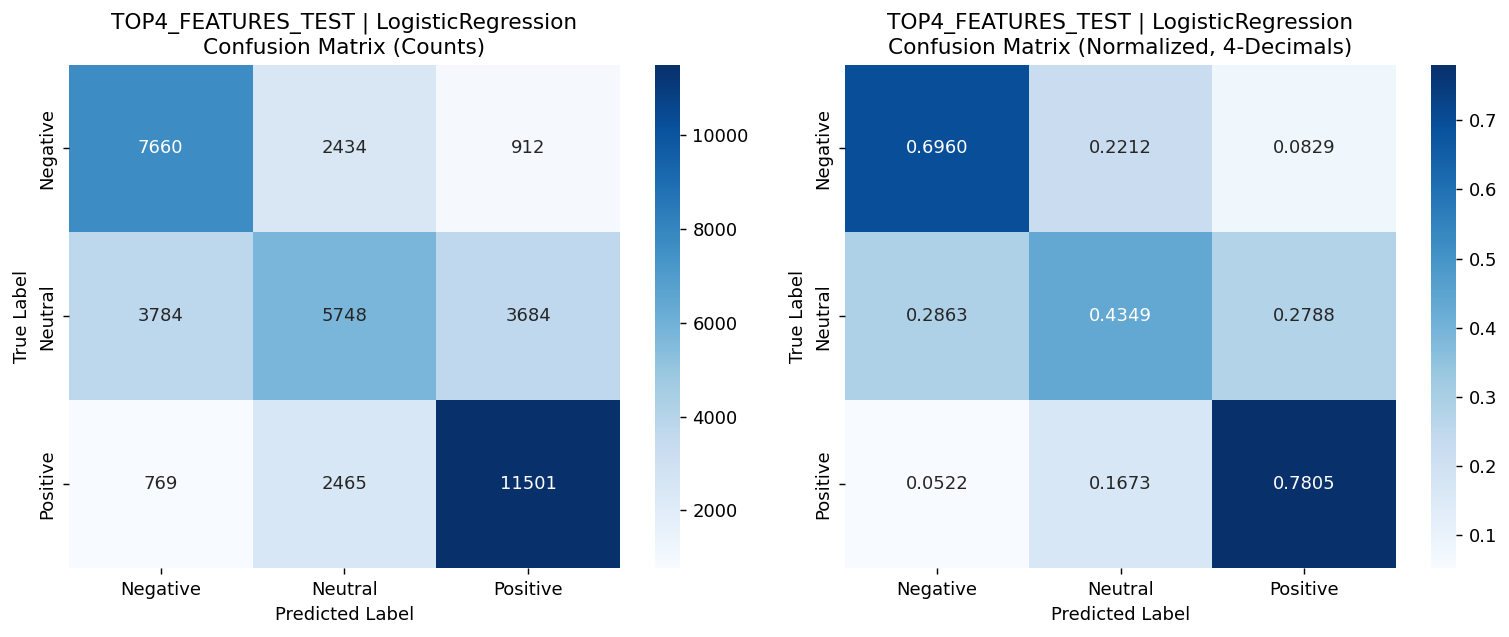


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6272  Recall=0.6960  F1=0.6598  Support=11006
Neutral   : Precision=0.5399  Recall=0.4349  F1=0.4817  Support=13216
Positive  : Precision=0.7145  Recall=0.7805  F1=0.7460  Support=14735

✅ Model saved to: /content/drive/MyDrive/THESIS 47/ClassicML_Multiclass/TOP4_FEATURES/LogReg_TOP4_Multiclass.pkl

SUMMARY - LogReg TOP 4 Features (Multiclass)
Train Accuracy: 0.6866 | F1_weighted: 0.6807
Test  Accuracy: 0.6394 | F1_weighted: 0.6320



In [21]:
# ======================================================================
# LOGISTIC REGRESSION — TOP 4 FEATURES (Multiclass with Class Weights)
# Features: reviewText, title, genre, tomatoMeter
# ======================================================================

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

setup = "TOP4_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"LOGISTIC REGRESSION — TOP 4 FEATURES (Multiclass)")
print(f"{'='*70}")

# ---- BUILD TOP-4 FEATURE MATRICES ----
print("\nBuilding TOP-4 feature matrices...")

# 1. Review Text (already cleaned)
Xtr_review_top4 = Xtr_review
Xte_review_top4 = Xte_review

# 2. Title Text (already cleaned)
Xtr_title_top4 = Xtr_title
Xte_title_top4 = Xte_title

# 3. Genre (MultiLabelBinarizer)
mlb_4 = MultiLabelBinarizer()
Xtr_genre_4 = mlb_4.fit_transform(train_genre).astype(np.float32)
Xte_genre_4 = mlb_4.transform(test_genre).astype(np.float32)
Xtr_genre_4 = sparse.csr_matrix(Xtr_genre_4)
Xte_genre_4 = sparse.csr_matrix(Xte_genre_4)

# 4. tomatoMeter (numeric)
NUM_COLS_4 = ['tomatoMeter']
scaler_4, Xtr_num_np_4 = fit_scale_numeric(train_df, NUM_COLS_4)
Xte_num_np_4 = transform_scale_numeric(scaler_4, test_df, NUM_COLS_4)
Xtr_num_4 = sparse.csr_matrix(Xtr_num_np_4.astype(np.float32))
Xte_num_4 = sparse.csr_matrix(Xte_num_np_4.astype(np.float32))

# Stack TOP-4
X_train_TOP4 = sparse.hstack([Xtr_review_top4, Xtr_title_top4, Xtr_genre_4, Xtr_num_4], format='csr')
X_test_TOP4  = sparse.hstack([Xte_review_top4, Xte_title_top4, Xte_genre_4, Xte_num_4], format='csr')

print(f"X_train_TOP4 shape: {X_train_TOP4.shape}")
print(f"X_test_TOP4 shape:  {X_test_TOP4.shape}")

# ---- HYPERPARAMETER SEARCH (Strong L2 Regularization) ----
print("\nSearching for optimal C with strong L2 regularization...")
cs_grid = np.logspace(-4, -1, 10)  # 0.0001 to 0.1
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

logreg_cv = LogisticRegressionCV(
    Cs=cs_grid,
    cv=inner_cv,
    penalty="l2",
    solver="lbfgs",
    max_iter=4000,
    multi_class='multinomial',  # ⭐ CRITICAL for multiclass
    class_weight=class_weight_dict,  # ⭐ Handle class imbalance
    n_jobs=-1,
    scoring="f1_weighted",  # ⭐ Use weighted F1 for imbalanced multiclass
    refit=True,
    random_state=RNG
)

logreg_cv.fit(X_train_TOP4, y_train)
best_C = float(logreg_cv.C_[0])
print(f"Selected optimal C: {best_C:.6f}")

# ---- FINAL MODEL WITH TUNED C ----
logreg_top4 = LogisticRegression(
    penalty="l2",
    C=best_C,
    solver="lbfgs",
    max_iter=4000,
    n_jobs=-1,
    multi_class='multinomial',
    class_weight=class_weight_dict,
    random_state=RNG
)

# ---- K-FOLD CROSS-VALIDATION ----
print("\nRunning 5-Fold Cross-Validation with tuned C...")
kfold_cv_report(logreg_top4, X_train_TOP4, y_train, "LogReg (TOP 4 Features)")

# ---- FIT ON FULL TRAIN ----
print("\nTraining on full training set...")
logreg_top4.fit(X_train_TOP4, y_train)

# ---- PREDICTIONS ----
train_pred = logreg_top4.predict(X_train_TOP4)
test_pred = logreg_top4.predict(X_test_TOP4)

try:
    test_prob = logreg_top4.predict_proba(X_test_TOP4)
    train_prob = logreg_top4.predict_proba(X_train_TOP4)
except Exception:
    test_prob = None
    train_prob = None

# ---- EVALUATION ----
print(f"\n{'='*70}")
print("TRAIN SET PERFORMANCE")
print(f"{'='*70}")
train_metrics = evaluate_and_plot(
    "LogisticRegression",
    f"{setup}_TRAIN",
    y_train,
    train_prob,
    train_pred,
    save_dir
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE")
print(f"{'='*70}")
test_metrics = evaluate_and_plot(
    "LogisticRegression",
    f"{setup}_TEST",
    y_test,
    test_prob,
    test_pred,
    save_dir
)

# ---- SAVE MODEL ----
model_path = os.path.join(save_dir, "LogReg_TOP4_Multiclass.pkl")
with open(model_path, "wb") as f:
    pickle.dump({
        "model": logreg_top4,
        "best_C": best_C,
        "tfidf_review": tfidf_review,
        "tfidf_title": tfidf_title,
        "scaler": scaler_4,
        "mlb": mlb_4,
        "num_cols": NUM_COLS_4,
        "class_names": class_names,
        "class_weight_dict": class_weight_dict
    }, f)

print(f"\n✅ Model saved to: {model_path}")
print(f"\n{'='*70}")
print(f"SUMMARY - LogReg TOP 4 Features (Multiclass)")
print(f"{'='*70}")
print(f"Train Accuracy: {train_metrics['accuracy']:.4f} | F1_weighted: {train_metrics['f1_weighted']:.4f}")
print(f"Test  Accuracy: {test_metrics['accuracy']:.4f} | F1_weighted: {test_metrics['f1_weighted']:.4f}")
print(f"{'='*70}\n")


LOGISTIC REGRESSION — TEXT ONLY (Multiclass)
X_train_TEXT shape: (155827, 60000)
X_test_TEXT shape:  (38957, 60000)

Searching for optimal C with strong L2 regularization...
Selected optimal C: 0.100000

Running 5-Fold Cross-Validation with tuned C...
  Fold 1: acc=0.5810 | f1_weighted=0.5761
  Fold 2: acc=0.5765 | f1_weighted=0.5713
  Fold 3: acc=0.5797 | f1_weighted=0.5734
  Fold 4: acc=0.5778 | f1_weighted=0.5727
  Fold 5: acc=0.5818 | f1_weighted=0.5763
  LogReg (TEXT ONLY) CV mean±std | acc=0.5793±0.0020 f1_w=0.5740±0.0019

Training on full training set...

TRAIN SET PERFORMANCE

[TEXTONLY_FEATURE_TRAIN | LogisticRegression]
Accuracy=0.6347  F1_weighted=0.6303  Precision_weighted=0.6312  Recall_weighted=0.6347

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.6018    0.6841    0.6403     44023
     Neutral     0.5805    0.4766    0.5234     52865
    Positive     0.6987    0.7396    0.7186     58939

    ac

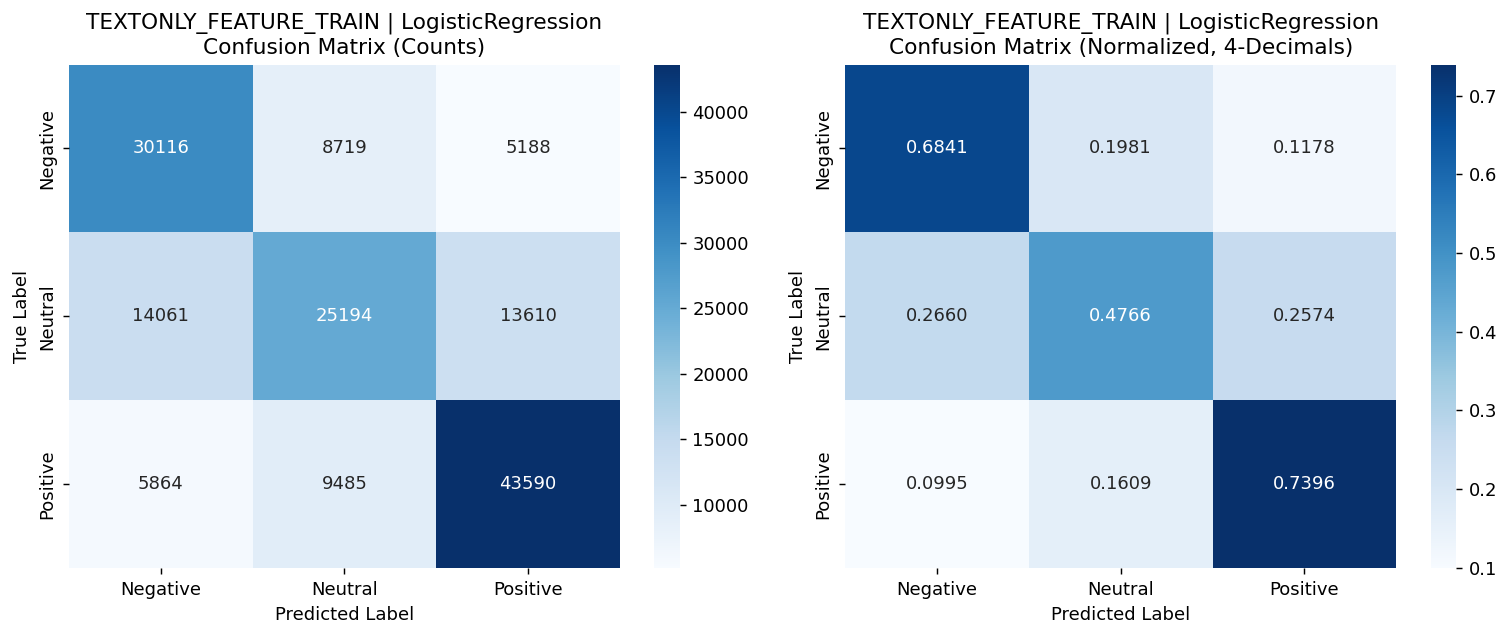


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6018  Recall=0.6841  F1=0.6403  Support=44023
Neutral   : Precision=0.5805  Recall=0.4766  F1=0.5234  Support=52865
Positive  : Precision=0.6987  Recall=0.7396  F1=0.7186  Support=58939

TEST SET PERFORMANCE

[TEXTONLY_FEATURE_TEST | LogisticRegression]
Accuracy=0.5842  F1_weighted=0.5790  Precision_weighted=0.5787  Recall_weighted=0.5842

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.5497    0.6248    0.5849     11006
     Neutral     0.5031    0.4122    0.4531     13216
    Positive     0.6681    0.7082    0.6876     14735

    accuracy                         0.5842     38957
   macro avg     0.5736    0.5817    0.5752     38957
weighted avg     0.5787    0.5842    0.5790     38957



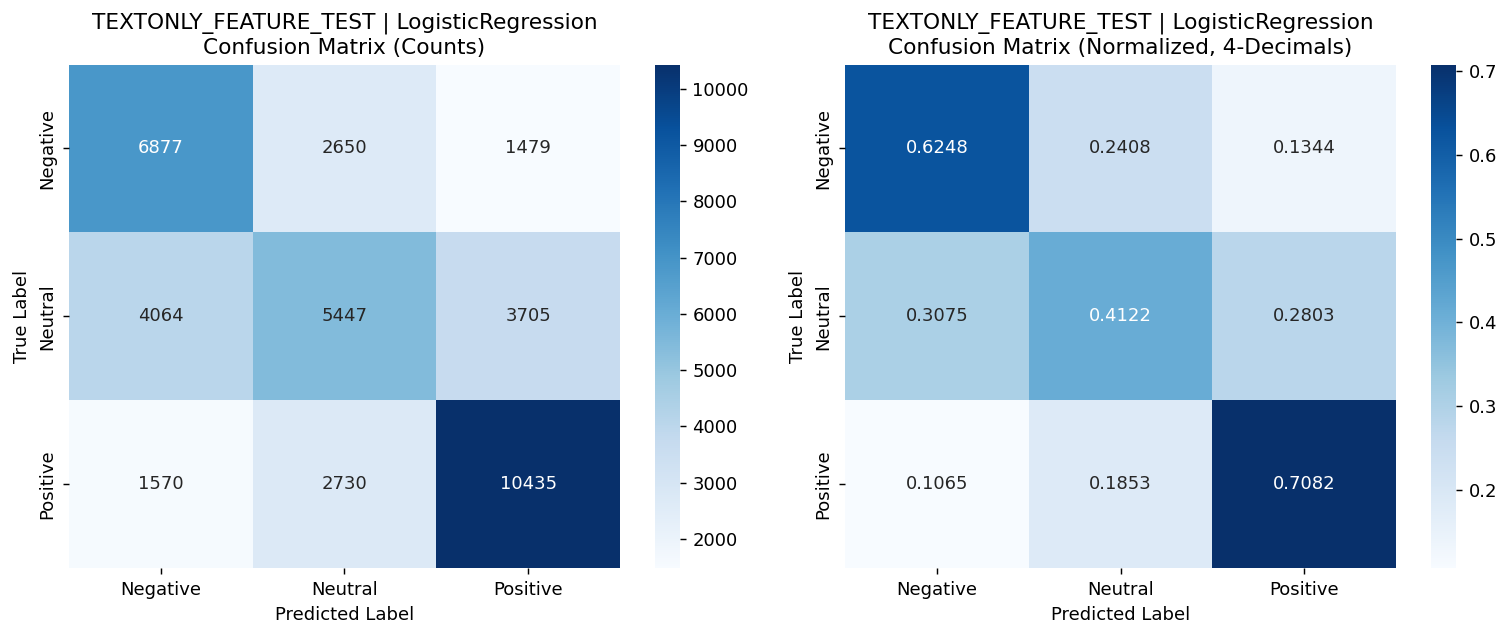


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.5497  Recall=0.6248  F1=0.5849  Support=11006
Neutral   : Precision=0.5031  Recall=0.4122  F1=0.4531  Support=13216
Positive  : Precision=0.6681  Recall=0.7082  F1=0.6876  Support=14735

✅ Model saved to: /content/drive/MyDrive/THESIS 47/ClassicML_Multiclass/TEXTONLY_FEATURE/LogReg_TEXTONLY_Multiclass.pkl

SUMMARY - LogReg TEXT ONLY (Multiclass)
Train Accuracy: 0.6347 | F1_weighted: 0.6303
Test  Accuracy: 0.5842 | F1_weighted: 0.5790



In [22]:
# ======================================================================
# LOGISTIC REGRESSION — TEXT ONLY (Multiclass with Class Weights)
# Feature: reviewText (TF-IDF)
# ======================================================================

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

setup = "TEXTONLY_FEATURE"
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"LOGISTIC REGRESSION — TEXT ONLY (Multiclass)")
print(f"{'='*70}")

# ---- USE REVIEW TEXT ONLY ----
X_train_TEXT = Xtr_review
X_test_TEXT  = Xte_review

print(f"X_train_TEXT shape: {X_train_TEXT.shape}")
print(f"X_test_TEXT shape:  {X_test_TEXT.shape}")

# ---- HYPERPARAMETER SEARCH (Strong L2 Regularization) ----
print("\nSearching for optimal C with strong L2 regularization...")
cs_grid = np.logspace(-4, -1, 10)  # 0.0001 to 0.1
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

logreg_cv = LogisticRegressionCV(
    Cs=cs_grid,
    cv=inner_cv,
    penalty="l2",
    solver="lbfgs",
    max_iter=4000,
    multi_class='multinomial',  # ⭐ CRITICAL for multiclass
    class_weight=class_weight_dict,  # ⭐ Handle class imbalance
    n_jobs=-1,
    scoring="f1_weighted",  # ⭐ Use weighted F1 for imbalanced multiclass
    refit=True,
    random_state=RNG
)

logreg_cv.fit(X_train_TEXT, y_train)
best_C = float(logreg_cv.C_[0])
print(f"Selected optimal C: {best_C:.6f}")

# ---- FINAL MODEL WITH TUNED C ----
logreg_text = LogisticRegression(
    penalty="l2",
    C=best_C,
    solver="lbfgs",
    max_iter=4000,
    n_jobs=-1,
    multi_class='multinomial',
    class_weight=class_weight_dict,
    random_state=RNG
)

# ---- K-FOLD CROSS-VALIDATION ----
print("\nRunning 5-Fold Cross-Validation with tuned C...")
kfold_cv_report(logreg_text, X_train_TEXT, y_train, "LogReg (TEXT ONLY)")

# ---- FIT ON FULL TRAIN ----
print("\nTraining on full training set...")
logreg_text.fit(X_train_TEXT, y_train)

# ---- PREDICTIONS ----
train_pred = logreg_text.predict(X_train_TEXT)
test_pred = logreg_text.predict(X_test_TEXT)

try:
    test_prob = logreg_text.predict_proba(X_test_TEXT)
    train_prob = logreg_text.predict_proba(X_train_TEXT)
except Exception:
    test_prob = None
    train_prob = None

# ---- EVALUATION ----
print(f"\n{'='*70}")
print("TRAIN SET PERFORMANCE")
print(f"{'='*70}")
train_metrics = evaluate_and_plot(
    "LogisticRegression",
    f"{setup}_TRAIN",
    y_train,
    train_prob,
    train_pred,
    save_dir
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE")
print(f"{'='*70}")
test_metrics = evaluate_and_plot(
    "LogisticRegression",
    f"{setup}_TEST",
    y_test,
    test_prob,
    test_pred,
    save_dir
)

# ---- SAVE MODEL ----
model_path = os.path.join(save_dir, "LogReg_TEXTONLY_Multiclass.pkl")
with open(model_path, "wb") as f:
    pickle.dump({
        "model": logreg_text,
        "best_C": best_C,
        "tfidf_review": tfidf_review,
        "class_names": class_names,
        "class_weight_dict": class_weight_dict
    }, f)

print(f"\n✅ Model saved to: {model_path}")
print(f"\n{'='*70}")
print(f"SUMMARY - LogReg TEXT ONLY (Multiclass)")
print(f"{'='*70}")
print(f"Train Accuracy: {train_metrics['accuracy']:.4f} | F1_weighted: {train_metrics['f1_weighted']:.4f}")
print(f"Test  Accuracy: {test_metrics['accuracy']:.4f} | F1_weighted: {test_metrics['f1_weighted']:.4f}")
print(f"{'='*70}\n")


LOGISTIC REGRESSION — ALL FEATURES (Multiclass with Optimal C)

Searching for optimal C with strong L2 regularization...
Selected optimal C: 0.100000

Running 5-Fold Cross-Validation with tuned C...

Training on full training set...

TRAIN SET PERFORMANCE

[ALL_FEATURES_CV_TRAIN | LogisticRegression]
Accuracy=0.6899  F1_weighted=0.6846  Precision_weighted=0.6848  Recall_weighted=0.6899

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.6727    0.7479    0.7083     44023
     Neutral     0.6233    0.5135    0.5631     52865
    Positive     0.7490    0.8047    0.7759     58939

    accuracy                         0.6899    155827
   macro avg     0.6817    0.6887    0.6824    155827
weighted avg     0.6848    0.6899    0.6846    155827



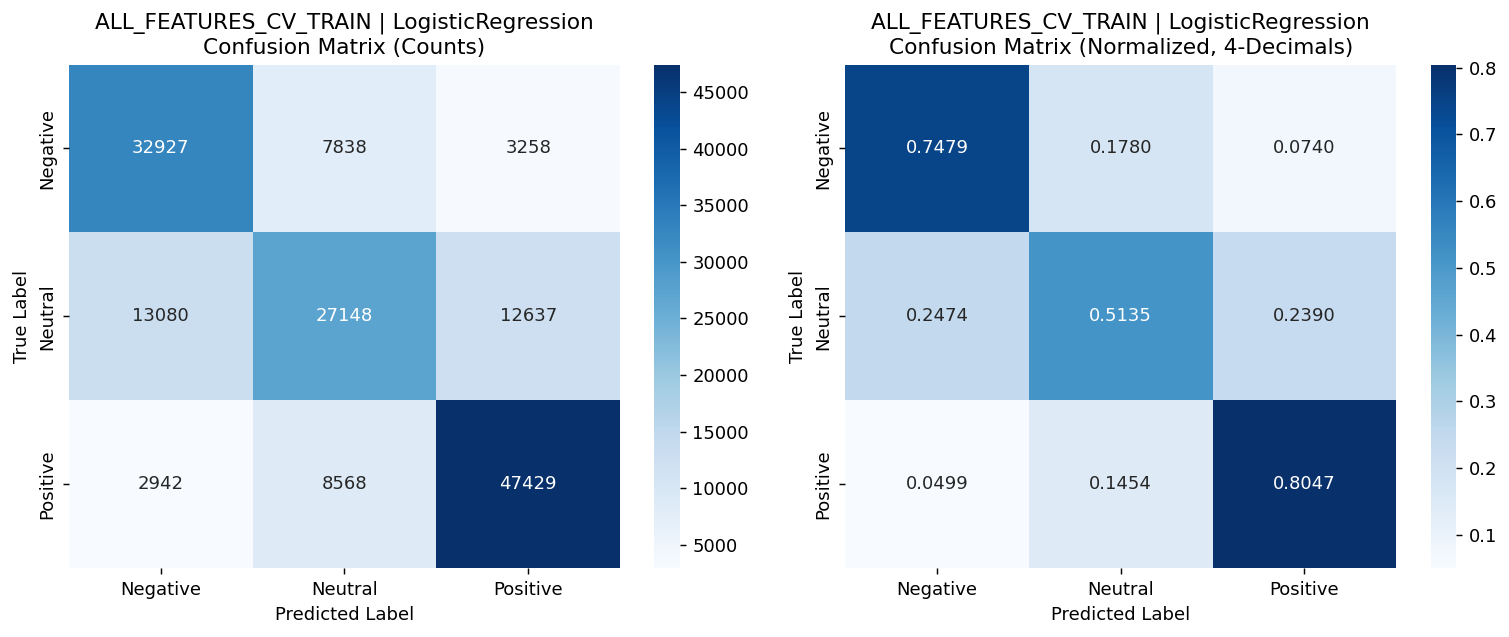


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6727  Recall=0.7479  F1=0.7083  Support=44023
Neutral   : Precision=0.6233  Recall=0.5135  F1=0.5631  Support=52865
Positive  : Precision=0.7490  Recall=0.8047  F1=0.7759  Support=58939

TEST SET PERFORMANCE

[ALL_FEATURES_CV_TEST | LogisticRegression]
Accuracy=0.6418  F1_weighted=0.6351  Precision_weighted=0.6336  Recall_weighted=0.6418

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.6265    0.6970    0.6598     11006
     Neutral     0.5403    0.4423    0.4865     13216
    Positive     0.7226    0.7794    0.7499     14735

    accuracy                         0.6418     38957
   macro avg     0.6298    0.6396    0.6321     38957
weighted avg     0.6336    0.6418    0.6351     38957



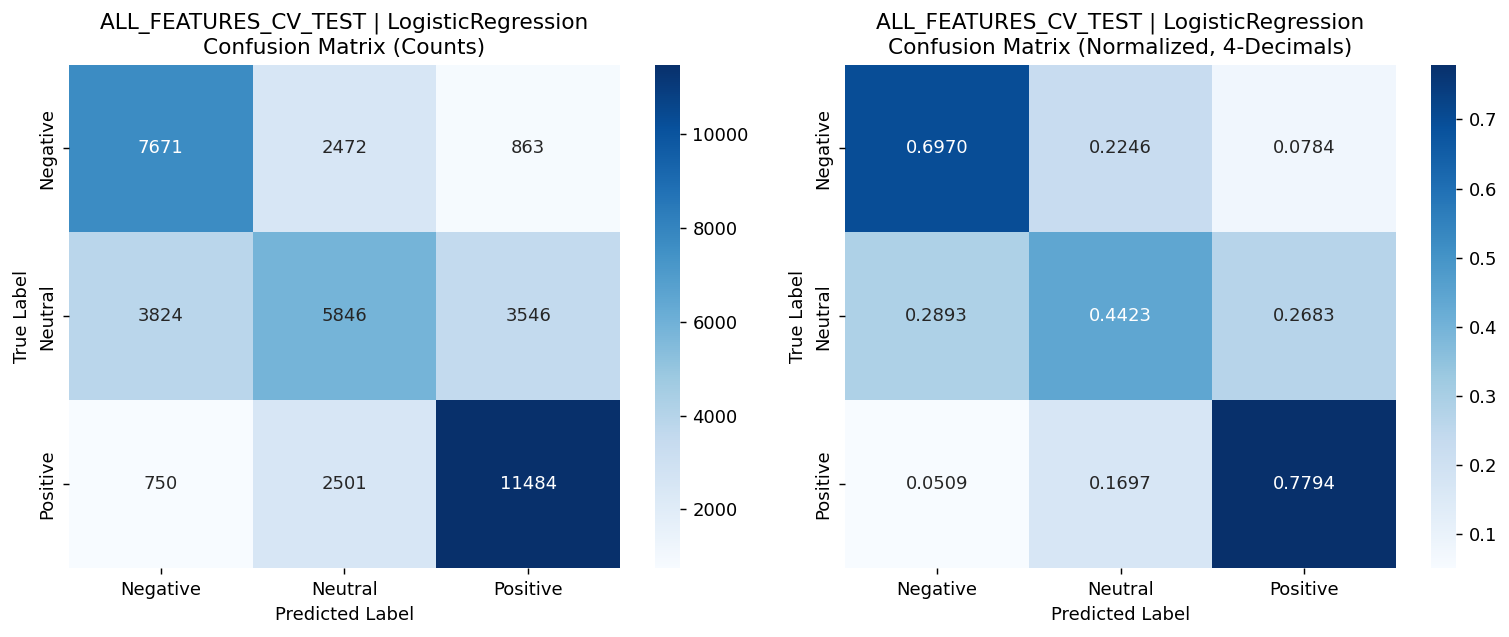


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6265  Recall=0.6970  F1=0.6598  Support=11006
Neutral   : Precision=0.5403  Recall=0.4423  F1=0.4865  Support=13216
Positive  : Precision=0.7226  Recall=0.7794  F1=0.7499  Support=14735

✅ Model saved to: /content/drive/MyDrive/THESIS 47/ClassicML_Multiclass/ALL_FEATURES_CV/LogReg_ALL_Multiclass_CV.pkl

SUMMARY - LogReg ALL Features (Multiclass with Optimal C)
Train Accuracy: 0.6899 | F1_weighted: 0.6846
Test  Accuracy: 0.6418 | F1_weighted: 0.6351



In [24]:
# ======================================================================
# LOGISTIC REGRESSION — ALL FEATURES (Multiclass with Class Weights)
# --- NOW WITH OPTIMAL C SEARCH ---
# ======================================================================

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold # Assuming StratifiedKFold is available

setup = "ALL_FEATURES_CV" # Updated setup name to reflect CV tuning
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"LOGISTIC REGRESSION — ALL FEATURES (Multiclass with Optimal C)")
print(f"{'='*70}")

# --- HYPERPARAMETER SEARCH (Strong L2 Regularization) ---
print("\nSearching for optimal C with strong L2 regularization...")
# Testing C values from 0.0001 to 0.1 (stronger regularization than default C=1.0)
cs_grid = np.logspace(-4, -1, 10)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

# NOTE: The ALL_FEATURES matrix is very high-dimensional, so this CV process will take a long time (20+ minutes per fold).
logreg_cv_all = LogisticRegressionCV(
    Cs=cs_grid,
    cv=inner_cv,
    penalty="l2",
    solver="lbfgs",
    max_iter=4000, # Increased max_iter for stability with high dimensionality
    multi_class='multinomial',
    class_weight=class_weight_dict,
    n_jobs=-1,
    scoring="f1_weighted", # Use weighted F1 for imbalanced multiclass
    refit=True,
    random_state=RNG
)

logreg_cv_all.fit(X_train_ALL, y_train)
best_C_all = float(logreg_cv_all.C_[0])
print(f"Selected optimal C: {best_C_all:.6f}")

# --- FINAL MODEL WITH TUNED C ---
logreg_all = LogisticRegression(
    penalty="l2",
    C=best_C_all, # ⭐ Using the optimal C found by CV
    solver="lbfgs",
    max_iter=4000,
    n_jobs=-1,
    multi_class='multinomial',
    class_weight=class_weight_dict,
    random_state=RNG
)

# ---- K-FOLD CROSS-VALIDATION (Tuned Model) ----
# Note: The performance here should closely match the best C from the CV search
print("\nRunning 5-Fold Cross-Validation with tuned C...")
# kfold_cv_report(logreg_all, X_train_ALL, y_train, "LogReg (ALL Features)") # Optional: if you want the report again

# ---- FIT ON FULL TRAIN ----
# This fit is relatively fast since the CV search already warmed up the system
print("\nTraining on full training set...")
logreg_all.fit(X_train_ALL, y_train)

# ---- PREDICTIONS ----
train_pred = logreg_all.predict(X_train_ALL)
test_pred = logreg_all.predict(X_test_ALL)

try:
    test_prob = logreg_all.predict_proba(X_test_ALL)
    train_prob = logreg_all.predict_proba(X_train_ALL)
except Exception as e:
    test_prob = None
    train_prob = None
    print(f"Warning: Could not get probability scores: {e}")

# ---- EVALUATION ----
print(f"\n{'='*70}")
print("TRAIN SET PERFORMANCE")
print(f"{'='*70}")
train_metrics = evaluate_and_plot(
    "LogisticRegression",
    f"{setup}_TRAIN",
    y_train,
    train_prob,
    train_pred,
    save_dir
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE")
print(f"{'='*70}")
test_metrics = evaluate_and_plot(
    "LogisticRegression",
    f"{setup}_TEST",
    y_test,
    test_prob,
    test_pred,
    save_dir
)

# ---- SAVE MODEL ----
model_path = os.path.join(save_dir, "LogReg_ALL_Multiclass_CV.pkl")
with open(model_path, "wb") as f:
    pickle.dump({
        "model": logreg_all,
        "best_C": best_C_all,
        "tfidf_review": tfidf_review,
        "tfidf_title": tfidf_title,
        "scaler": scaler_all,
        "mlb": mlb_all,
        "ohe": ohe_all,
        "num_cols": NUM_COLS,
        "class_names": class_names,
        "class_weight_dict": class_weight_dict
    }, f)

print(f"\n✅ Model saved to: {model_path}")
print(f"\n{'='*70}")
print(f"SUMMARY - LogReg ALL Features (Multiclass with Optimal C)")
print(f"{'='*70}")
print(f"Train Accuracy: {train_metrics['accuracy']:.4f} | F1_weighted: {train_metrics['f1_weighted']:.4f}")
print(f"Test  Accuracy: {test_metrics['accuracy']:.4f} | F1_weighted: {test_metrics['f1_weighted']:.4f}")
print(f"{'='*70}\n")